###COVID Rx Analysis with age consideration
Author: Erica Okene (contractor, GAP solutions) ak21@cdc.gov

COVID Population, Definitions, and Codesets generated by Heartley Egwuogu (contractor, GAP solutions) tog0@cdc.gov for LAVA Respiratory Virus Dashboard

FTE Support: Julia Raykin qiz8@cdc.gov

Started on 12/20/2024

In [0]:
from itertools import chain
from pyspark.sql.types import StructField, StructType, StringType, IntegerType
from pyspark.sql import SparkSession, functions as F, Row
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import datetime as dt

### Relevant externaly created notebooks and links,imported into this notebook
- cdh_truveta_exploratory.tog0_truveta_encounterv2 -Encounter Table ([Notebook](https://adb-5189663741904016.16.azuredatabricks.net/editor/notebooks/4481497015918153?o=5189663741904016)). This table is the modified Truveta encounter table that includes icu,imv and deaths. You may use the Truveta encounter table if icu,imv and deaths are not abstracted in your project. NOTE:The encounterv2 table must be rerun, to refresh table, at least weekly
- cdh_truveta_exploratory.ak21_truveta_MMWR_umc High-Risk/Undeylying Medical Condition ([Notebook](https://adb-5189663741904016.16.azuredatabricks.net/editor/notebooks/4186368583545589?o=5189663741904016)). This table contains the ICD10 codes for the High Risk Conditions and Underlying Medical Conditions

### Applicable Rules
1. All Covid patients is defined as patients with diagnosis of covid or positive labs over 65 
2. Only patients with outpatient (ambulatory) encounters occuring within seasons
- a. Summer 2023 (2023-06-01 to 2023-09-30)
- b. Fall/Winter 2023 - 2024 (2023-10-01 to 2024-03-30)
- c. Summer 2024 (2024-06-01 to 2024-09-30)
3. The following exclusions apply:
- a. all Patients with a COVID-19 inpatient event during the study period
- b. all Patients with a COVID-19 inpatient event 1 month prior or 2 weeks following an outpatient event during study period
- c. all Patients with a COVID-19 diagnosis 6 months prior to index COVID event
4. Inpatients are defined as having conceptcode in ('1065215','1065220','1065223','1065603'): Outpatients are defined as having conceptcode in ('1065216'); emergency patients are defined as having conceptcode in ('1065217','3058549')
5. Date of onset is defined as index date i.e. the first time occurence of diagnosis or positive lab
7. Demographic vars including age, sex, HHS region are identified at index date.
8. All covid patients are counted once in the year-month and season of the index date
9. Covid medications are considered as administration or dispensation of covid medications including paxlovid or molnupiravir or remdesivir. 
10. Covid medications administration or dispensation window is set to  [0,14] of index date

### Covid Population Defined
Patients are included in this analysis based on encounters occuring in the study perio with the COVID codes below (covid diagnosis or lab)

M table derived in LAVA, modified in this notebook table altered to include only medications dispensed  or administered after 2023/06/01


Seasons were updated to reflect Project Proposal
- summer 2024 (June 1 – Sept 30, 2024), 
- fall/winter 2023-2024 (Oct 1, 2023 – March 1, 2024), 
- summer 2023 (June 1- Sept 30, 2023). 
We will exclude all cases outside of the above three dates in our analysis.


### Generate Target Population Table with conditions
####Population characteristics addressed here: 
- Age: include only >=65
- Age groups established

####Follow up time:
- Treatment population include med dispense or admin within 14 days
#### Outcomes addressed:
- Time to treatment flag established

#### Underlying medical conditions:
- [COVID UMC list and associated codes](https://adb-5189663741904016.16.azuredatabricks.net/editor/notebooks/4186368583545589?o=5189663741904016)
- time to treatment flag established
- vaccination flag established (does not include vax within 2 months of index event)

In [0]:
%sql
select count(distinct personid) as count from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc

count
249348


In [0]:
df_totsbySeason1 = spark.sql("""SELECT
                             season, 
                             count (distinct personid) as count
                             from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
                             where season is not null
                             group by season
""").toPandas()   
df_totsbySeason1.display()

##Population estimates in studio: Sum23 = 84K, FW2324 = 138K**DNA, Sum24 = 97K,

season,count
Summer 2023,80369
Fall/Winter 2023-2024,119031
Summer 2024,99279


In [0]:
df_trtmentbySeason1 = spark.sql("""SELECT
                             season,
                             count (distinct personid) as count
                             from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
                             where season is not null
                             and medflag=1
                             group by season

""").toPandas() 
df_trtmentbySeason1.display()
##Population estimates in studio: Sum23 = 9.2K**DNA, FW2324 = 21K, Sum24 = 16K

season,count
Summer 2023,12865
Fall/Winter 2023-2024,20334
Summer 2024,15330


In [0]:
df_trtmentrateSeason = pd.merge(df_totsbySeason1, df_trtmentbySeason1, on='season', how='left')
df_trtmentrateSeason['%treated'] = round((df_trtmentbySeason1['count']/df_totsbySeason1['count'])*100)
df_trtmentrateSeason = df_trtmentrateSeason.rename(columns={'count_x':'covid','count_y':'treated'})

season_names = {'Summer 2023' : 'Season 1',
                'Fall/Winter 2023-2024': 'Season 2',
                'Summer 2024': 'Season 3'}
df_trtmentrateSeason = df_trtmentrateSeason.replace({"season": season_names})
df_trtmentrateSeason.display()

season,covid,treated,%treated
Season 1,80369,12865,16.0
Season 2,119031,20334,17.0
Season 3,99279,15330,15.0


In [0]:
df_totsbySeasonAge1 = spark.sql("""SELECT
                             season, agesi,
                             count (distinct personid) as count
                             from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
                             where season is not null
                             group by season, agesi
                             order by season,agesi
""").toPandas() 
df_totsbySeasonAge1.display()

season,agesi,count
Fall/Winter 2023-2024,65-69yr,33798
Fall/Winter 2023-2024,70-74yr,31252
Fall/Winter 2023-2024,75-79yr,25780
Fall/Winter 2023-2024,80-84yr,16046
Fall/Winter 2023-2024,85-89yr,8116
Fall/Winter 2023-2024,90+yr,4039
Summer 2023,65-69yr,22949
Summer 2023,70-74yr,21498
Summer 2023,75-79yr,17276
Summer 2023,80-84yr,10748


In [0]:
df_trtmentbySeasonAge = spark.sql("""SELECT
                             season,
                             agesi,
                             count (distinct personid) as count
                             from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
                             where season is not null
                             and medflag=1
                             group by season,agesi
                             order by season,agesi

""").toPandas()   
df_trtmentbySeasonAge.display()

#Counts from Prose B with enc and date bound
##S23 3130, 2902, 2312, 1390, 594, 303

##FW2324 5654, 5276, 4209, 2553, 1168, 600

##s24 3918, 3881, 3101, 1874, 836, 372


season,agesi,count
Fall/Winter 2023-2024,65-69yr,5759
Fall/Winter 2023-2024,70-74yr,5489
Fall/Winter 2023-2024,75-79yr,4522
Fall/Winter 2023-2024,80-84yr,2660
Fall/Winter 2023-2024,85-89yr,1299
Fall/Winter 2023-2024,90+yr,605
Summer 2023,65-69yr,3672
Summer 2023,70-74yr,3468
Summer 2023,75-79yr,2869
Summer 2023,80-84yr,1725


In [0]:
df_trtmentbySeasonAge = spark.sql("""SELECT
                             season,
                             agesi,
                             count (distinct personid) as count
                             from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
                             where season = "Summer 2023"
                             and medflag=1
                             group by season,agesi
                             order by season,agesi

""").toPandas()   
df_trtmentbySeasonAge.display()

season,agesi,count
Summer 2023,65-69yr,3672
Summer 2023,70-74yr,3468
Summer 2023,75-79yr,2869
Summer 2023,80-84yr,1725
Summer 2023,85-89yr,784
Summer 2023,90+yr,347


In [0]:
df_trtmentbySeasonAge = spark.sql("""SELECT
                             season,
                             agesi,
                             count (distinct personid) as count
                             from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
                             where season = "Fall/Winter 2023-2024"
                             and medflag=1
                             group by season,agesi
                             order by season,agesi

""").toPandas()   
df_trtmentbySeasonAge.display()

season,agesi,count
Fall/Winter 2023-2024,65-69yr,5759
Fall/Winter 2023-2024,70-74yr,5489
Fall/Winter 2023-2024,75-79yr,4522
Fall/Winter 2023-2024,80-84yr,2660
Fall/Winter 2023-2024,85-89yr,1299
Fall/Winter 2023-2024,90+yr,605


In [0]:
df_trtmentbySeasonAge = spark.sql("""SELECT
                             season,
                             agesi,
                             count (distinct personid) as count
                             from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
                             where season = "Summer 2024"
                             and medflag=1
                             group by season,agesi
                             order by season,agesi

""").toPandas()   
df_trtmentbySeasonAge.display()

season,agesi,count
Summer 2024,65-69yr,4099
Summer 2024,70-74yr,4240
Summer 2024,75-79yr,3551
Summer 2024,80-84yr,2047
Summer 2024,85-89yr,932
Summer 2024,90+yr,461


In [0]:
df_totsbySeasonSex = spark.sql("""SELECT
                             season,gender,
                             count (distinct personid) as count
                             from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
                             where season is not null
                             group by season,gender
                             order by season,gender
""")   
df_totsbySeasonGender.display()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-3128328979303249>, line 9
      1 df_totsbySeasonSex = spark.sql("""SELECT
      2                              season,gender,
      3                              count (distinct personid) as count
   (...)
      7                              order by season,gender
      8 """)   
----> 9 df_totsbySeasonGender.display()

NameError: name 'df_totsbySeasonGender' is not defined

In [0]:
df_totsbySeasonRaceEth = spark.sql("""SELECT
                             season,race_ethnicity,
                             count (distinct personid) as count
                             from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
                             where season is not null
                             group by season,race_ethnicity
                             order by season,race_ethnicity
""")   
df_totsbySeasonRaceEth.display()

season,race_ethnicity,count
Fall/Winter 2023-2024,"AI/AN, Hispanic or Latino",39
Fall/Winter 2023-2024,"AI/AN, non-Hispanic",344
Fall/Winter 2023-2024,"Asian, Hispanic or Latino",220
Fall/Winter 2023-2024,"Asian, non-Hispanic",3845
Fall/Winter 2023-2024,"Black, Hispanic or Latino",120
Fall/Winter 2023-2024,"Black, non-Hispanic",8213
Fall/Winter 2023-2024,"NH/PI, Hispanic or Latino",21
Fall/Winter 2023-2024,"NH/PI, non-Hispanic",174
Fall/Winter 2023-2024,Unknown/Other,15071
Fall/Winter 2023-2024,"White, Hispanic or Latino",4528


In [0]:
dfumcbySeason = spark.sql("""SELECT season,umc, count (distinct personid) as count
                             from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
                             where season is not null
                             group by season,umc
                             order by season
""")
dfumcbySeason.display()


season,umc,count
Fall/Winter 2023-2024,sterrx,5857
Fall/Winter 2023-2024,cliv,9707
Fall/Winter 2023-2024,cad,32297
Fall/Winter 2023-2024,parkins,942
Fall/Winter 2023-2024,primimm,939
Fall/Winter 2023-2024,cf,32
Fall/Winter 2023-2024,disab,37713
Fall/Winter 2023-2024,vax,5998
Fall/Winter 2023-2024,asthma,22005
Fall/Winter 2023-2024,stemtransp,209


In [0]:
%sql
select season,
count(distinct personid) as count 
from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
where 12msterrxflag = 1
and season is not null
group by season


season,count
Summer 2023,3533
Fall/Winter 2023-2024,4438
Summer 2024,3591


In [0]:
%sql
select season,
count(distinct personid) as count 
from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
where vaxflag = 1
and season is not null
group by season


season,count
Summer 2023,3921
Fall/Winter 2023-2024,5803
Summer 2024,4972


In [0]:
%sql
select season,
count(distinct personid) as count 
from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
where 6mvaxflag = 1
and season is not null
group by season


season,count
Summer 2023,959
Fall/Winter 2023-2024,1468
Summer 2024,1346


In [0]:
%sql
select season,
ttrxflag,
count(distinct personid) as count 
from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
where season is not null
group by season,ttrxflag
sort by season, ttrxflag

season,ttrxflag,count
Fall/Winter 2023-2024,+/- 1 day,18702
Fall/Winter 2023-2024,+/- 2 days,568
Fall/Winter 2023-2024,+/- 3 days,257
Fall/Winter 2023-2024,+/- 4 days,205
Fall/Winter 2023-2024,+/- 5 days,155
Fall/Winter 2023-2024,+/- 6 days,168
Fall/Winter 2023-2024,+/- 7 days,186
Fall/Winter 2023-2024,> 7 days,3128
Fall/Winter 2023-2024,no treatment,95963
Summer 2023,+/- 1 day,12209


In [0]:
%sql
select season,
meds,
count(distinct personid) as count 
from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
where season is not null
group by season,meds
sort by season, meds

season,meds,count
Fall/Winter 2023-2024,null,95963
Fall/Winter 2023-2024,mol,3072
Fall/Winter 2023-2024,pax,20141
Fall/Winter 2023-2024,rem,2
Summer 2023,null,65545
Summer 2023,mol,2123
Summer 2023,pax,12802
Summer 2024,null,82377
Summer 2024,mol,1419
Summer 2024,pax,15597


In [0]:
%sql
select season, personid,
umc
from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
where season is not null

season,personid,umc
Summer 2023,00009ee4-081e-975f-cc74-8bb83c93416b,cad
Summer 2023,00009ee4-081e-975f-cc74-8bb83c93416b,heart
Summer 2023,00009ee4-081e-975f-cc74-8bb83c93416b,canc
Summer 2023,00009ee4-081e-975f-cc74-8bb83c93416b,smoker
Summer 2024,00009ee4-081e-975f-cc74-8bb83c93416b,cad
Summer 2024,00009ee4-081e-975f-cc74-8bb83c93416b,heart
Summer 2024,00009ee4-081e-975f-cc74-8bb83c93416b,canc
Summer 2024,00009ee4-081e-975f-cc74-8bb83c93416b,smoker
Summer 2023,0002504e-3492-1ab4-5aaf-2eeaa77c98f0,sevobes
Summer 2023,0002504e-3492-1ab4-5aaf-2eeaa77c98f0,cad


In [0]:
%sql
select 
  season, 
  umc_count, 
  count(distinct personid) as personid_count
  from (select 
    season, 
    personid,
    case   
      when count(distinct umc) = 0 then '0 conditions'
      when count(distinct umc) = 1 then '1 condition'
      when count(distinct umc) = 2 then '2 conditions'
      else '>=3 conditions'
    end as umc_count 
  from  cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
  where season is not null
  group by season, personid)
  group by season, umc_count
  order by season, umc_count

season,umc_count,personid_count
Fall/Winter 2023-2024,0 conditions,13370
Fall/Winter 2023-2024,1 condition,11960
Fall/Winter 2023-2024,2 conditions,14514
Fall/Winter 2023-2024,>=3 conditions,79115
Summer 2023,0 conditions,8722
Summer 2023,1 condition,7772
Summer 2023,2 conditions,9305
Summer 2023,>=3 conditions,54516
Summer 2024,0 conditions,10948
Summer 2024,1 condition,10084


Plots for treatment rate by season

In [0]:
df_plot1arx = spark.sql('''SELECT agesi,
                        count(case when medflag = 1 then personid end) as count_rx
                   from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
        WHERE season="Summer 2023"
        GROUP BY agesi
        ORDER BY agesi
''').toPandas()
display(df_plot1arx)

df_plot2arx = spark.sql('''SELECT agesi,
                        count(distinct personid) as count_rx
                   from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
        WHERE season="Summer 2023" and medflag = 1
        GROUP BY agesi
        ORDER BY agesi
''').toPandas()
display(df_plot2arx)

agesi,count_rx
65-69yr,19506
70-74yr,20773
75-79yr,19168
80-84yr,11703
85-89yr,5751
90+yr,2580


agesi,count_rx
65-69yr,3566
70-74yr,3363
75-79yr,2806
80-84yr,1667
85-89yr,756
90+yr,337


In [0]:
df_plot1atot = spark.sql('''SELECT agesi,
                      count(distinct personid) as count_tot
                   from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
        WHERE season="Summer 2023"
        GROUP BY agesi
        ORDER BY agesi
''').toPandas()

display(df_plot1atot)

df_plot1arx = spark.sql('''SELECT agesi,
                        count(distinct personid) as count_rx
                   from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
        WHERE season="Summer 2023" and medflag = 1
        GROUP BY agesi
        ORDER BY agesi
''').toPandas()

display(df_plot1arx)



agesi,count_tot
65-69yr,22935
70-74yr,21479
75-79yr,17266
80-84yr,10743
85-89yr,5181
90+yr,2711


agesi,count_rx
65-69yr,3566
70-74yr,3363
75-79yr,2806
80-84yr,1667
85-89yr,756
90+yr,337


Text(0.01, -0.2, 'Data Source: Truveta electronic health records data from 20 U.S. health systems \n*Total outpatients age 65+ in Truveta Health Records with positive lab and/or COVID-19 diagnosis \n**Percent of patients who received a treatment within 14 days out of total encounters in each age group.')

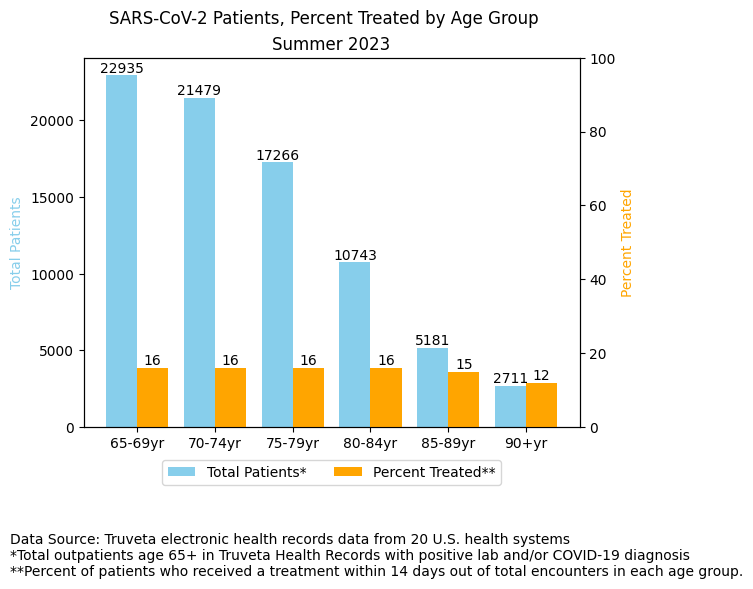

In [0]:
labels = ['65-69yr','70-74yr','75-79yr','80-84yr','85-89yr','90+yr']


gwidth = 0.8
gspace = 0.4
positions = np.arange(len(labels))

heights1 = []
heights2 = []
for label in labels:
    heights1.append(df_plot1atot[df_plot1atot['agesi']==label]['count_tot'].values[0])
    heights2.append(round(df_plot1arx[df_plot1arx['agesi']==label]['count_rx'].values[0]/df_plot1atot[df_plot1atot['agesi']==label]['count_tot'].values[0]*100))
    

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
bar1 = ax1.bar(positions, heights1, gwidth/2, align="center", label="Total Patients*", color="skyblue")
bar2 = ax2.bar(positions+gspace, heights2, gwidth/2, align="center", label="Percent Treated**", color="orange")
ax1.bar_label(bar1, label_type="edge")
ax2.bar_label(bar2, label_type="edge", fmt="%g")
       
ax1.set_xticks(positions + gwidth/4)
ax1.set_xticklabels(labels)
#ax1.set_xlabel("Age Group")
ax1.set_ylabel("Total Patients").set_color("skyblue")
ax2.set_ylabel("Percent Treated").set_color("orange")
ax2.set_ylim(0, 100)

bars = [bar1, bar2]
labs = [b.get_label() for b in bars]
ax1.legend(bars, labs, loc='lower center', bbox_to_anchor=(0.5, -0.175), ncol=len(labels)/2)
#sns.despine(left=True)
#ax1.set_style("whitegrid")

plt.suptitle("SARS-CoV-2 Patients, Percent Treated by Age Group")
plt.title("Summer 2023")
plt.figtext(0.01, -0.20, "Data Source: Truveta electronic health records data from 20 U.S. health systems \n*Total outpatients age 65+ in Truveta Health Records with positive lab and/or COVID-19 diagnosis \n**Percent of patients who received a treatment within 14 days out of total encounters in each age group.", fontsize=10)

In [0]:
df_plot1btot = spark.sql('''SELECT agesi,
                      count(distinct personid) as count_tot
                   from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
        WHERE season="Fall/Winter 2023-2024"
        GROUP BY agesi
        ORDER BY agesi
''').toPandas()

display(df_plot1btot)

df_plot1brx = spark.sql('''SELECT agesi,
                        count(distinct personid) as count_rx
                   from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
        WHERE season="Fall/Winter 2023-2024" and medflag = 1
        GROUP BY agesi
        ORDER BY agesi
''').toPandas()

display(df_plot1brx)



agesi,count_tot
65-69yr,33775
70-74yr,31232
75-79yr,25768
80-84yr,16037
85-89yr,8109
90+yr,4038


agesi,count_rx
65-69yr,5425
70-74yr,5245
75-79yr,4263
80-84yr,2513
85-89yr,1235
90+yr,563


Text(0.01, -0.2, 'Data Source: Truveta electronic health records data from 20 U.S. health systems \n*Total outpatients age 65+ in Truveta Health Records with positive lab and/or COVID-19 diagnosis \n**Percent of patients who received a treatment within 14 days out of total encounters in each age group.')

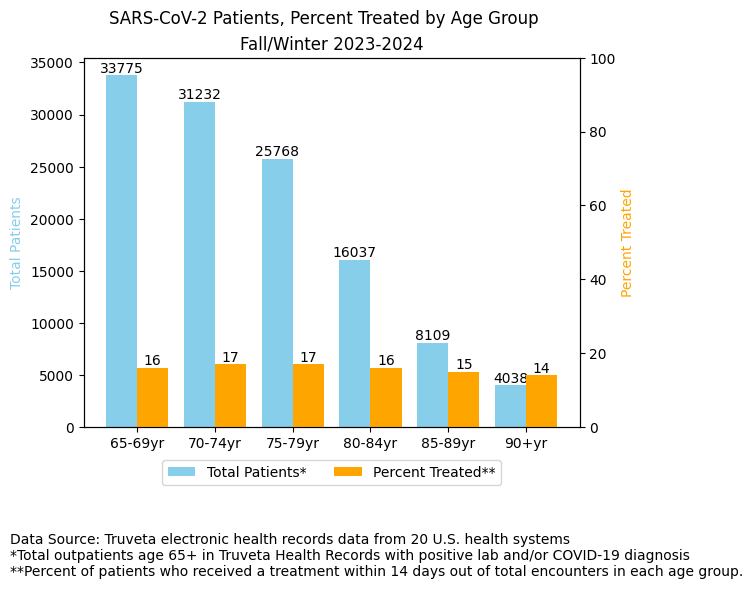

In [0]:
labels = ['65-69yr','70-74yr','75-79yr','80-84yr','85-89yr','90+yr']


gwidth = 0.8
gspace = 0.4
positions = np.arange(len(labels))

heights1 = []
heights2 = []
for label in labels:
    heights1.append(df_plot1btot[df_plot1btot['agesi']==label]['count_tot'].values[0])
    heights2.append(round(df_plot1brx[df_plot1brx['agesi']==label]['count_rx'].values[0]/df_plot1btot[df_plot1btot['agesi']==label]['count_tot'].values[0]*100))
    

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
bar1 = ax1.bar(positions, heights1, gwidth/2, align="center", label="Total Patients*", color="skyblue")
bar2 = ax2.bar(positions+gspace, heights2, gwidth/2, align="center", label="Percent Treated**", color="orange")
ax1.bar_label(bar1, label_type="edge")
ax2.bar_label(bar2, label_type="edge", fmt="%g")
       
ax1.set_xticks(positions + gwidth/4)
ax1.set_xticklabels(labels)
#ax1.set_xlabel("Age Group")edav_prd_cdh.cdh_truveta.medicationstatement
ax1.set_ylabel("Total Patients").set_color("skyblue")
ax2.set_ylabel("Percent Treated").set_color("orange")
ax2.set_ylim(0, 100)

bars = [bar1, bar2]
labs = [b.get_label() for b in bars]
ax1.legend(bars, labs, loc='lower center', bbox_to_anchor=(0.5, -0.175), ncol=len(labels)/2)
#sns.despine(left=True)
#ax1.set_style("whitegrid")

plt.suptitle("SARS-CoV-2 Patients, Percent Treated by Age Group")
plt.title("Fall/Winter 2023-2024")
plt.figtext(0.01, -0.20, "Data Source: Truveta electronic health records data from 20 U.S. health systems \n*Total outpatients age 65+ in Truveta Health Records with positive lab and/or COVID-19 diagnosis \n**Percent of patients who received a treatment within 14 days out of total encounters in each age group.", fontsize=10)

In [0]:
df_plot1ctot = spark.sql('''SELECT agesi,
                      count(distinct personid) as count_tot
                   from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
        WHERE season="Summer 2024"
        GROUP BY agesi
        ORDER BY agesi
''').toPandas()

display(df_plot1ctot)

df_plot1crx = spark.sql('''SELECT agesi,
                        count(distinct personid) as count_rx
                   from cdh_truveta_exploratory.ak21_truveta_MMWR_rx_tpop_enc
        WHERE season="Summer 2024" and medflag = 1
        GROUP BY agesi
        ORDER BY agesi
''').toPandas()

display(df_plot1crx)



agesi,count_tot
65-69yr,26661
70-74yr,26546
75-79yr,22268
80-84yr,13573
85-89yr,6858
90+yr,3397


agesi,count_rx
65-69yr,3779
70-74yr,3952
75-79yr,3308
80-84yr,1907
85-89yr,864
90+yr,424


Text(0.01, -0.2, 'Data Source: Truveta electronic health records data from 20 U.S. health systems \n*Total outpatients age 65+ in Truveta Health Records with positive lab and/or COVID-19 diagnosis \n**Percent of patients who received a treatment within 14 days out of total encounters in each age group.')

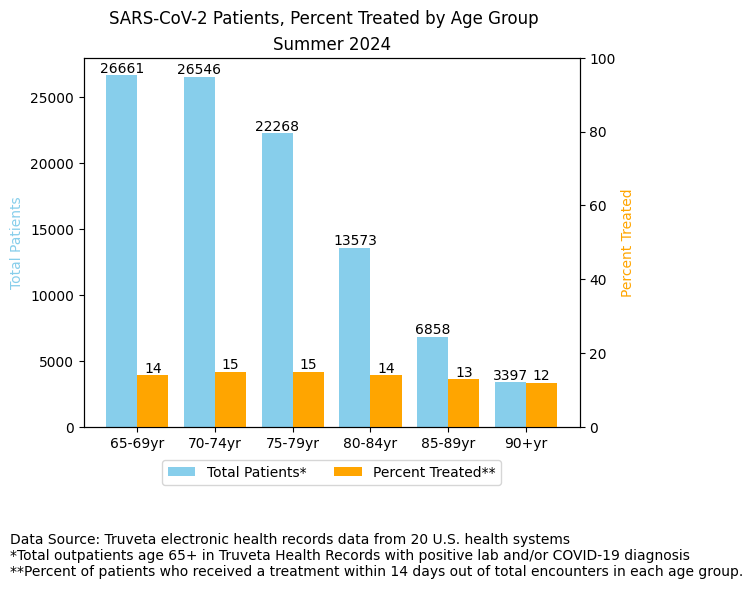

In [0]:
labels = ['65-69yr','70-74yr','75-79yr','80-84yr','85-89yr','90+yr']


gwidth = 0.8
gspace = 0.4
positions = np.arange(len(labels))

heights1 = []
heights2 = []
for label in labels:
    heights1.append(df_plot1ctot[df_plot1ctot['agesi']==label]['count_tot'].values[0])
    heights2.append(round(df_plot1crx[df_plot1crx['agesi']==label]['count_rx'].values[0]/df_plot1ctot[df_plot1ctot['agesi']==label]['count_tot'].values[0]*100))
    

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
bar1 = ax1.bar(positions, heights1, gwidth/2, align="center", label="Total Patients*", color="skyblue")
bar2 = ax2.bar(positions+gspace, heights2, gwidth/2, align="center", label="Percent Treated**", color="orange")
ax1.bar_label(bar1, label_type="edge")
ax2.bar_label(bar2, label_type="edge", fmt="%g")
       
ax1.set_xticks(positions + gwidth/4)
ax1.set_xticklabels(labels)
#ax1.set_xlabel("Age Group")
ax1.set_ylabel("Total Patients").set_color("skyblue")
ax2.set_ylabel("Percent Treated").set_color("orange")
ax2.set_ylim(0, 100)

bars = [bar1, bar2]
labs = [b.get_label() for b in bars]
ax1.legend(bars, labs, loc='lower center', bbox_to_anchor=(0.5, -0.175), ncol=len(labels)/2)
#sns.despine(left=True)
#ax1.set_style("whitegrid")

plt.suptitle("SARS-CoV-2 Patients, Percent Treated by Age Group")
plt.title("Summer 2024")
plt.figtext(0.01, -0.20, "Data Source: Truveta electronic health records data from 20 U.S. health systems \n*Total outpatients age 65+ in Truveta Health Records with positive lab and/or COVID-19 diagnosis \n**Percent of patients who received a treatment within 14 days out of total encounters in each age group.", fontsize=10)